# Misharin (GSE127803) - QC and preprocessing
Mice aged 8-10 weeks were instilled intratracheally with control particles or crocidolite asbestos fibers to induce lung fibrosis. Lungs were then harvested at different time points (depending on the analysis method).

Single-cell RNA sequencing was done on a HiSeq 4000 instrument (Illumina) using Chromium Single Cell v2 Reagent Kit and Controller for the library preparation.

In [1]:
import helper_classes_DanielStrobl
import scanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scib
import seaborn as sns
import anndata

plt.rcParams['figure.figsize'] = (15, 15)
scanpy.settings.verbosity = 0
scanpy.settings.set_figure_params(
    dpi=50,
    facecolor="white",
    frameon=False,
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
base = "GSE127803_RAW"
output = "data/"

## 1. Reading and Preparing the Data

In [3]:
misharin_Daniel = scanpy.read(base + '/processed.h5ad')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_io/h5ad.py:280: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/Libr

In [3]:
# read in control data
mish_ctrl = scanpy.read(base + '/GSM3639113_SC14_matrix.mtx').transpose()
mish_ctrl.obs = pd.read_csv(base + '/GSM3639113_SC14_barcodes.tsv', header=None, sep='\t', names=["barcode"])
mish_ctrl.var = pd.read_csv(base + '/GSM3639113_SC14_genes.tsv', header=None, sep='\t', names=["gene", "gene_name"])
mish_ctrl.var.index = mish_ctrl.var["gene_name"]
mish_ctrl.obs["batch"] = 0

mish_ctrl.obs_names_make_unique()
mish_ctrl.var_names_make_unique()

In [4]:
# read in fibrosis data
mish_fibro = scanpy.read(base + '/GSM3639114_SC15_matrix.mtx').transpose()
mish_fibro.obs = pd.read_csv(base + '/GSM3639114_SC15_barcodes.tsv', header=None, sep='\t', names=["barcode"])
mish_fibro.var = pd.read_csv(base + '/GSM3639114_SC15_genes.tsv', header=None, sep='\t', names=["gene", "gene_name"])
mish_fibro.var.index = mish_fibro.var["gene_name"]
mish_fibro.obs["batch"] = 1

mish_fibro.obs_names_make_unique()
mish_fibro.var_names_make_unique()

In [5]:
misharin = anndata.concat([mish_ctrl, mish_fibro])
misharin

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 15453 × 27998
    obs: 'barcode', 'batch'

In [7]:
misharin.raw = misharin   # saving the raw counts because we need them later for merging with the other data sets

## 1.1. Creating 'batch numbers'

In [8]:
misharin.obs["barcode"] = misharin.obs["barcode"].str.split('-').str[0]
misharin.obs['cond'] = 'SC14'   # control
misharin.obs['cond'][misharin.obs.batch == 1] = 'SC15'   # fibrosis

misharin.obs_names = misharin.obs.cond + '_' + misharin.obs["barcode"]

misharin.obs = misharin.obs.drop(columns="barcode")
#misharin.var = misharin.var.drop(columns=[0,1]) --> TODO: ???

/var/folders/z_/nw0n7j9917b1t955zn7rj2vc0000gn/T/ipykernel_18942/982047180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misharin.obs['cond'][misharin.obs.batch == 1] = 'SC15'   # fibrosis


In [9]:
misharin.write(output + "misharin_Emma_raw.h5ad")

## 2. Quality Control

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


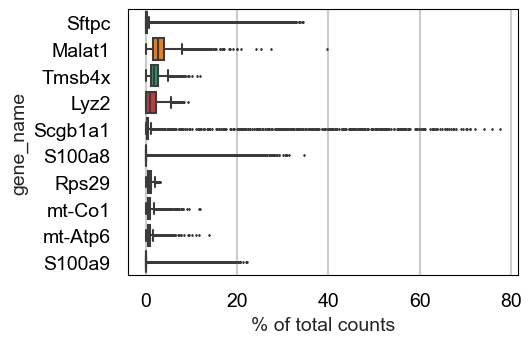

In [10]:
scanpy.pl.highest_expr_genes(misharin, n_top=10)

In [11]:
misharin.var_names_make_unique()
misharin

AnnData object with n_obs × n_vars = 15453 × 27998
    obs: 'batch', 'cond'

### 2.1. Filtering low quality reads
Cell QC is typically performed on the following three QC covariates:
- The number of counts per barcode (count depth)
- The number of genes per barcode
- The fraction of counts from mitochondrial genes per barcode

In [13]:
# mitochondrial genes
misharin.var["mt"] = misharin.var_names.str.startswith(("MT-", "mt-"))   # MT- --> human; mt- --> mouse
# ribosomal genes
misharin.var["ribo"] = misharin.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
misharin.var["hb"] = misharin.var_names.str.contains(("^HB[^(P)]"))

In [14]:
scanpy.pp.calculate_qc_metrics(
    misharin, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

- *n_genes_by_counts* in .obs is the number of genes with positive counts in a cell,
- *total_counts* is the total number of counts for a cell, this might also be known as library size, and
- *pct_counts_mt* is the proportion of total counts for a cell which are mitochondrial.

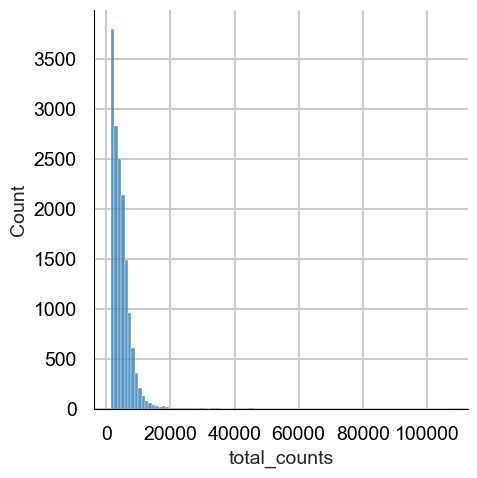

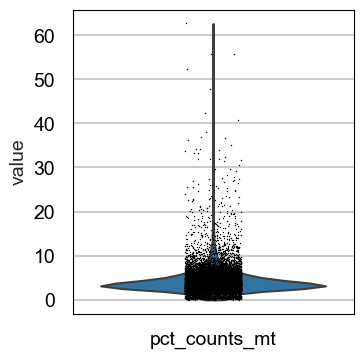

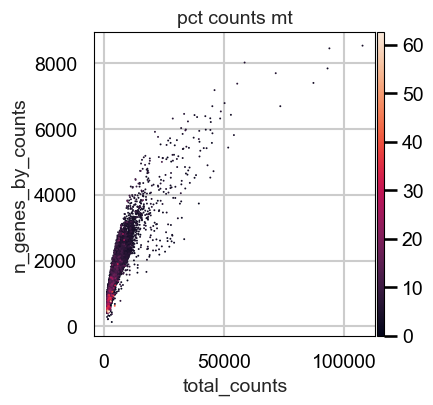

In [15]:
sns.displot(misharin.obs["total_counts"], bins=100, kde=False)
scanpy.pl.violin(misharin, "pct_counts_mt")
scanpy.pl.scatter(misharin, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [16]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [33]:
misharin.obs["outlier"] = (
    is_outlier(misharin, "log1p_total_counts", 7)
    | is_outlier(misharin, "log1p_n_genes_by_counts", 7)
    | is_outlier(misharin, "pct_counts_in_top_20_genes", 7)
)
misharin.obs.outlier.value_counts()   # using 7 MADs instead of 5 because otherwise too many cells are filtered out

False    14896
True       557
Name: outlier, dtype: int64

In [34]:
print(f"Total number of cells: {misharin.n_obs}")
misharin_7MADs = misharin[(~misharin.obs.outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {misharin_7MADs.n_obs}")

Total number of cells: 15453
Number of cells after filtering of low quality cells: 14896


In [35]:
misharin.obs["mt_outlier"] = is_outlier(misharin, "pct_counts_mt", 7) | ( misharin.obs["pct_counts_mt"] > 10)
misharin.obs.mt_outlier.value_counts()

False    14971
True       482
Name: mt_outlier, dtype: int64

In [36]:
print(f"Total number of cells: {misharin.n_obs}")
misharin_MADS_lowQuality = misharin[(~misharin.obs.outlier) & (~misharin.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {misharin_MADS_lowQuality.n_obs}")

Total number of cells: 15453
Number of cells after filtering of low quality cells: 14473


After filtering low-quality reads (7 MADs and 10% mitochondrial) only 14.473 cells left
--> in the paper 15.228 cells left after excluding doublets and low-quality cells.
--> no thresholds are mentioned in the paper

### 2.2. Filtering with code taken from the example notebook

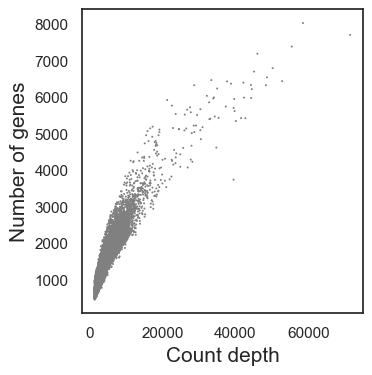

In [42]:
scib.pp.summarize_counts(misharin_MADS_lowQuality)
scib.pp.plot_qc(misharin_MADS_lowQuality)

**Filtering by:**
- max counts = 30000
- min genes = 400
- max genes = 5200

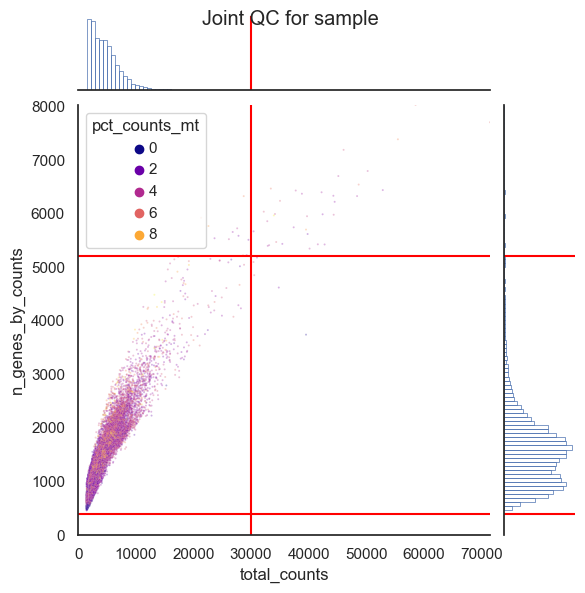

In [37]:
import sys
sys.path.insert(0, '/Users/emmaschonner/PycharmProjects/masterpraktikum_fibrosis_atlas/source')
import utils
utils.plot_qc_joint(misharin_MADS_lowQuality, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(400, 5200),   # total_counts
                    y_threshold=(0, 30000),    # n_genes_by_counts
                    title='Joint QC for sample ')

In [38]:
misharin_filtered = misharin.copy()

In [39]:
scanpy.pp.filter_cells(misharin_filtered, max_counts=30000)
scanpy.pp.filter_cells(misharin_filtered, max_genes=5200)
scanpy.pp.filter_cells(misharin_filtered, min_genes=400)

In [43]:
print(np.array(misharin_filtered.obs["pct_counts_mt"] > 20).sum())   # --> amount of cells most similar to paper with 20%
print(np.array(misharin_filtered.obs["pct_counts_mt"] > 15).sum())
print(np.array(misharin_filtered.obs["pct_counts_mt"] > 10).sum())

87
172
482


In [44]:
print(f"Total number of cells: {misharin.n_obs}")
misharin_filtered.obs["mt_outlier"] = misharin_filtered.obs["pct_counts_mt"] > 20
misharin_filtered = misharin_filtered[(~misharin_filtered.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {misharin_filtered.n_obs}")

Total number of cells: 15453
Number of cells after filtering of low quality cells: 15278


**Very similar to the 15.228 cells from the paper.**
--> another combination of MADs and mitochondrial percentage could also work

### 2.4. Doublet Detection (**not finished**)

In [514]:
import scrublet
scanpy.external.pp.scrublet(misharin_filtered)

ModuleNotFoundError: No module named 'scrublet'

## 3. Normalization

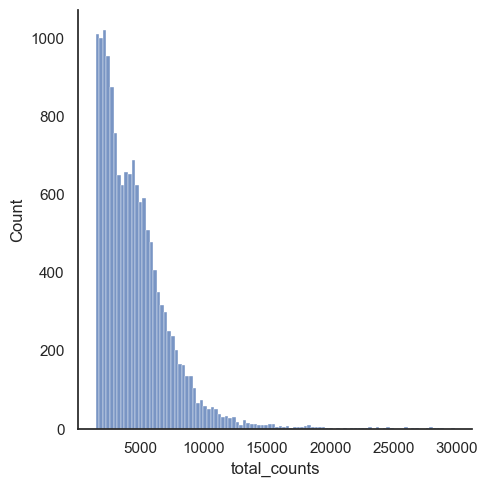

In [45]:
sns.displot(misharin_filtered.obs["total_counts"], bins=100, kde=False)   # total counts

In [46]:
scales_counts = scanpy.pp.normalize_total(misharin_filtered, target_sum=None, inplace=False)
# log1p transform
misharin_filtered.layers["log1p_norm"] = scanpy.pp.log1p(scales_counts["X"], copy=True)

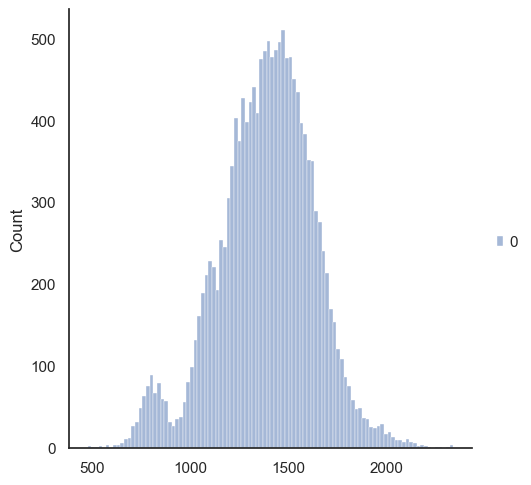

In [47]:
sns.displot(misharin_filtered.layers["log1p_norm"].sum(1), bins=100, kde=False)   # shifted logarithmus

## 4. Feature Selection
 --> using *sc.pp.highly_variable_genes*

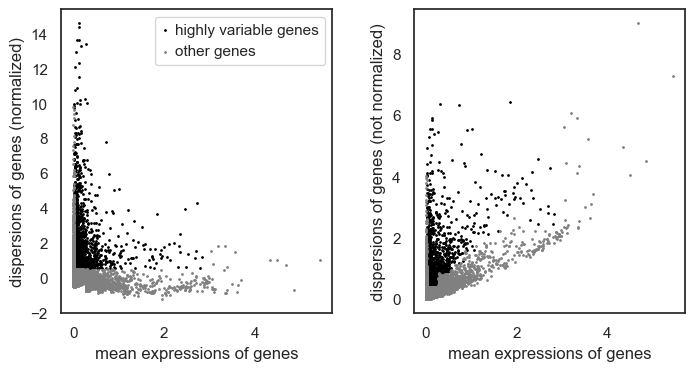

In [48]:
scanpy.pp.log1p(misharin_filtered)
scanpy.pp.highly_variable_genes(misharin_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(misharin_filtered)

## 3. Dimensionality Reduction

### 3.1. PCA

In [49]:
scanpy.pp.pca(misharin_filtered, svd_solver="arpack", use_highly_variable=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


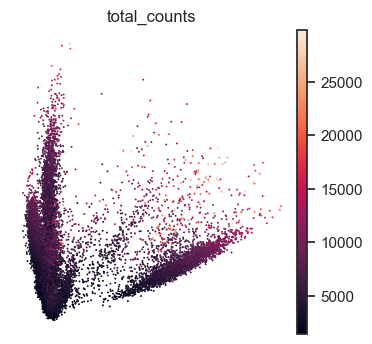

In [50]:
scanpy.pl.pca_scatter(misharin_filtered, color="total_counts")

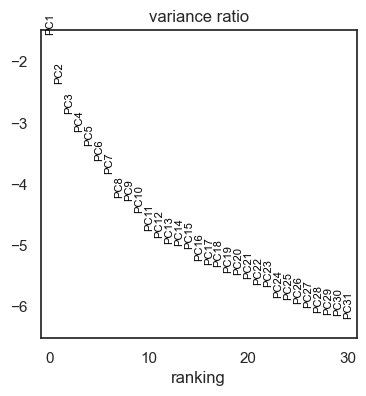

In [51]:
scanpy.pl.pca_variance_ratio(misharin_filtered, log=True)

### 3.2. UMAP

In [52]:
misharin_filtered.obs['cond']='control'                               # control
misharin_filtered.obs['cond'][misharin.obs.batch == 1] = 'fibrosis'   # fibrosis

/var/folders/z_/nw0n7j9917b1t955zn7rj2vc0000gn/T/ipykernel_18942/1689534151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misharin_filtered.obs['cond'][misharin.obs.batch == 1] = 'fibrosis'   # fibrosis


In [53]:
scanpy.pp.neighbors(misharin_filtered)
scanpy.tl.umap(misharin_filtered)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


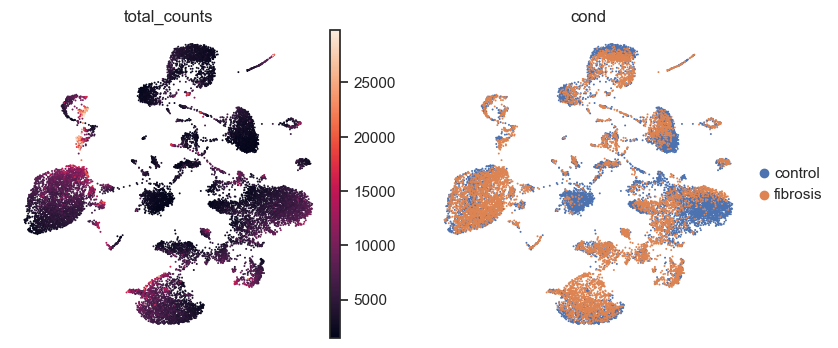

In [54]:
scanpy.pl.umap(misharin_filtered, color=["total_counts", "cond"])

## 4. Clustering

### 4.1. Louvain

In [55]:
scanpy.tl.louvain(misharin_filtered, resolution=0.4)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


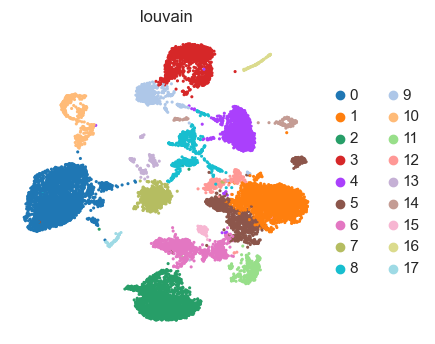

In [56]:
scanpy.pl.umap(misharin_filtered, color='louvain', size=20)

### 4.2. Leiden

In [57]:
scanpy.tl.leiden(misharin_filtered)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c

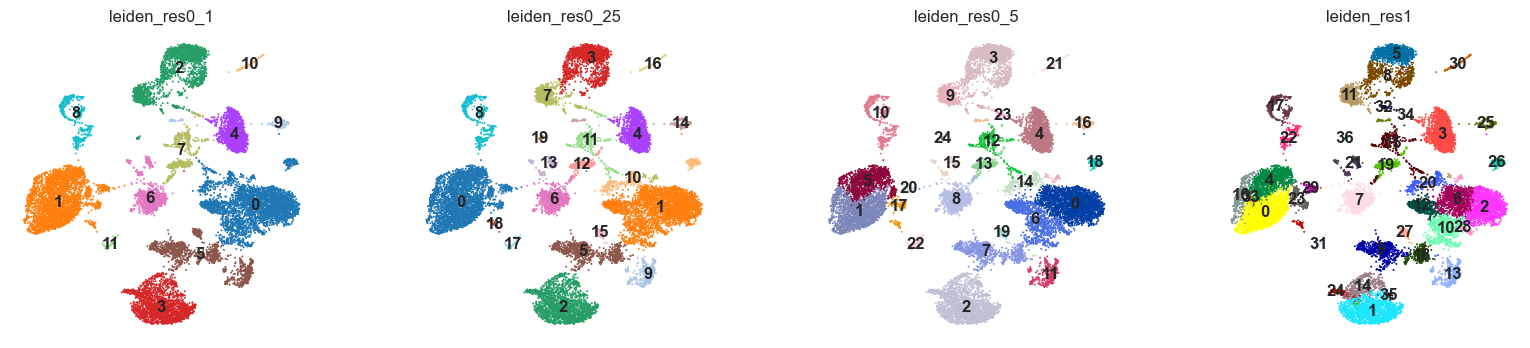

In [58]:
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_1", resolution=0.1)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_25", resolution=0.25)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_5", resolution=0.5)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res1", resolution=1.0)
scanpy.pl.umap(
    misharin_filtered,
    color=["leiden_res0_1","leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

## 5. Annotation
--> code taken from example notebook

In [59]:
mish_annot = pd.read_csv(base + '/misharin_clusters.csv', index_col=0)
mish_annot['batch'] = 0
mish_annot.loc[mish_annot.index.str.split('_').str[0]=='SC15', 'batch'] = 1

In [60]:
misharin_filtered.obs['mish_clusters'] = mish_annot.x.astype('category')

In [61]:
clusters = ['Classical monocytes', 'AT2', 'B cells', 'T cells', 'AT2_2', 'Non-classical monocytes', 'Alveolar macrophages', 'Neutrophils', 'Alveolar macrophages_2', 'Interstitial macrophages', 'NK cells', 'DC2', 'AT2_3', 'Endothelial-1', 'Secretory (club and goblet)', 'DC1', 'Endothelial-2 (alveolar capillaries )', 'T cells_2', 'Neutrophils_2', 'Alveolar macrophages (MoAM, Mmp12, Arg1)', 'Ciliated', 'AT2 cells (asbestos only, Retnla+)', 'Neutrophils_3', 'ILC (Id2, Gata3, Il7r)', 'AM', 'Proliferating AMs', 'pDC', 'Regulatory T cells', 'Fibroblasts', 'Ccr7+Ccl22+ DC', 'Doublets: AT2 and neutrophils', 'Mesothelium', 'AT1 cells', 'Proliferating DCs', 'Doublets: monocytes and B cells', 'Smooth muscle cells', 'Lymphatics', 'Doublets: AT2 and NK cells', 'Mast cells']

clusters = np.array(clusters)[list(misharin_filtered.obs.mish_clusters.cat.categories)]
misharin_filtered.obs.mish_clusters = misharin_filtered.obs.mish_clusters.cat.rename_categories(clusters)

## 6. Analyse Batch Effects

Batch and condition are identical:
- SC14 = 0 = Control
- SC15 = 1 = Fibrosis

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


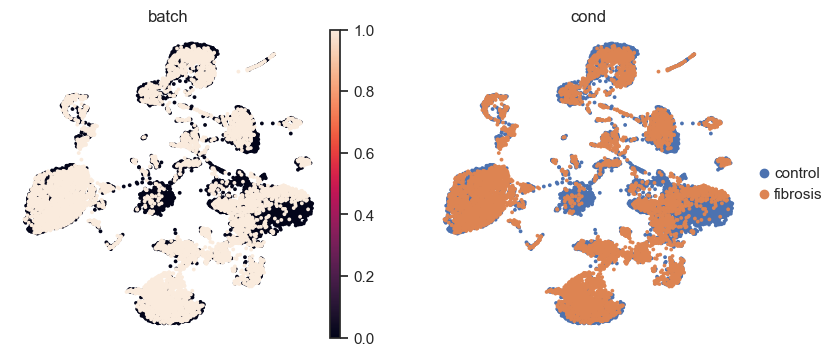

In [62]:
scanpy.pl.umap(misharin_filtered, color=['batch', 'cond'], size=30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


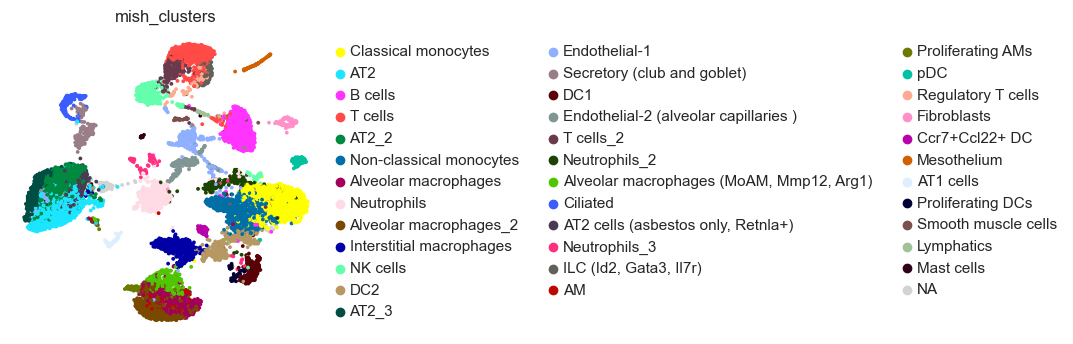

In [63]:
scanpy.pl.umap(misharin_filtered, color=['mish_clusters'], size=30)

Saving *misharin_filtered*:

In [64]:
misharin_filtered.write(output + "misharin_Emma_processed_without_annotation.h5ad")

In [65]:
misharin_filtered.obs

,batch,cond,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,...,log_counts,n_genes,mito_frac,louvain,leiden,leiden_res0_1,leiden_res0_25,leiden_res0_5,leiden_res1,mish_clusters
SC14_AAACCTGAGCGTTCCG,0,control,749,6.620073,1855.0,7.526179,25.606469,88.0,4.488636,4.743935,...,7.525640,749,0.0,4,3,4,4,4,3,B cells
SC14_AAACCTGAGGACATTA,0,control,629,6.445720,1479.0,7.299798,26.369168,56.0,4.043051,3.786342,...,7.299121,629,0.0,4,3,4,4,4,3,B cells
SC14_AAACCTGAGTCGTTTG,0,control,1180,7.074117,2638.0,7.878155,20.507961,118.0,4.779123,4.473086,...,7.877776,1180,0.0,2,1,3,2,2,1,Alveolar macrophages
SC14_AAACCTGCACATCCGG,0,control,2498,7.823646,9452.0,9.154087,16.314008,227.0,5.429346,2.401608,...,9.153981,2498,0.0,5,10,0,1,6,10,Classical monocytes
SC14_AAACCTGCACTAGTAC,0,control,1139,7.038784,3883.0,8.264621,24.671646,107.0,4.682131,2.755601,...,8.264363,1139,0.0,3,5,2,3,3,5,T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SC15_TTTGTCAGTGATGTGG,1,fibrosis,1141,7.040536,2724.0,7.910223,21.145374,89.0,4.499810,3.267254,...,7.909857,1141,0.0,5,12,0,1,6,12,Non-classical monocytes
SC15_TTTGTCAGTTCGCTAA,1,fibrosis,793,6.677083,2193.0,7.693481,26.265390,70.0,4.262680,3.191974,...,7.693026,793,0.0,3,5,2,3,3,5,T cells
SC15_TTTGTCATCAGTCAGT,1,fibrosis,1638,7.401842,4270.0,8.359603,18.056206,271.0,5.605802,6.346604,...,8.359369,1638,0.0,1,2,0,1,0,2,Classical monocytes
SC15_TTTGTCATCGCGTAGC,1,fibrosis,1803,7.497762,7743.0,8.954674,26.217228,206.0,5.332719,2.660467,...,8.954544,1803,0.0,15,27,5,15,19,27,Ccr7+Ccl22+ DC
